# Titanic Challenge

In [2]:
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install sklearn

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/titanic/test.csv
kaggle/input/titanic/titanic.zip
kaggle/input/titanic/train.csv
kaggle/input/titanic/gender_submission.csv


### Look for columns with missing values

In [4]:
t_train_orig = pd.read_csv("kaggle/input/titanic/train.csv")
t_train_orig.name = "Titanic Training Set"
t_test_orig = pd.read_csv("kaggle/input/titanic/test.csv")
t_test_orig.name = "Titanic Test Set"

def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




###  Women were much more likely to survive than men

In [5]:
t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### There's a correlation between ticket price and the likelihood of survival

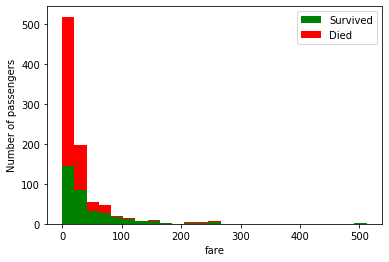

In [6]:
import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### Survival  is correlated best with class and fare
so we can fill in nulls with more representative values

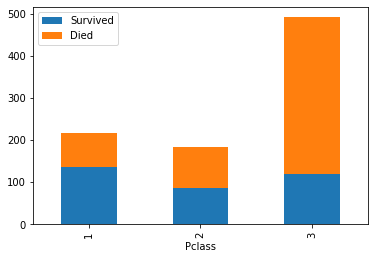

In [7]:
t_train_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .85)].groupby('Feature 1')
groups.get_group('Survived')

t_train_orig.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### See what  Age is correlated with best
so we can fill in nulls with more representative values

In [8]:
groups.get_group('Age')

,Feature 1,Feature 2,Correlation Coefficient
15,Age,Pclass,0.369226
20,Age,SibSp,0.308247
28,Age,Parch,0.189119


### Sample training data

In [9]:
t_train_orig.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
635,636,1,2,"Davis, Miss. Mary",female,28.0,0,0,237668,13.0000,NaN,S,0
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,0
90,91,0,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S,1
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,0
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,1
183,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S,0
663,664,0,3,"Coleff, Mr. Peju",male,36.0,0,0,349210,7.4958,NaN,S,1
176,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S,1
685,686,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C,1
622,623,1,3,"Nakid, Mr. Sahid",male,20.0,1,1,2653,15.7417,NaN,C,0


## Feature exploration

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)

### TODO

* Use this [[https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing]] to 

In [10]:
import math

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

# fill in missing fare with median fare for passengers in the same class
median_fares = t_train.groupby('Pclass')['Fare'].median()
def fare_for_class(row):
    return median_fares[row['Pclass']] if row['Fare'] == 0 else row['Fare']
t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# TODO: update AgeAdjusted to take into account title to refine the likely age, so that a child with
# missing age doesn't get classified as an adult.. a male child should be much more likely to survive
# so that should help

# extract titles
#get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
#all_titles = t_train['Title'].unique()
titles_esteemed_first = {
    'Countess.': 17,
    'Lady.': 16,
    'Rev.': 15,
    'Jonkheer.': 14,
    'Master.': 13,
    'Major.' : 12,
    'Don.': 11,
    'Dr.' : 10,
    'Col.': 9,
    'Capt.': 8,
    'Mlle.': 7,
    'Miss.': 6,
    'Ms.': 5,
    'Mrs.': 4,
    'Mme.': 3,
    'Sir.': 2,
    'Mr.': 1
}

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: titles_esteemed_first[title])


feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[np.isnan(t_train['Age']) & (t_train['Title'] == 'Miss.')][feature_cols].sample(12)

t_train[feature_cols].sample(12)

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
857,26.5500,1,0,1
666,13.0000,2,0,1
693,7.2250,3,0,1
642,27.9000,3,1,6
160,16.1000,3,0,1
433,7.1250,3,0,1
56,10.5000,2,1,6
778,7.7375,3,0,1
577,55.9000,1,1,4
374,21.0750,3,1,6


## Using a Decision Tree Classifier

In [11]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X = t_train[feature_cols]
y = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8208955223880597


## Using a Random Forrest Classifier

### Additional features

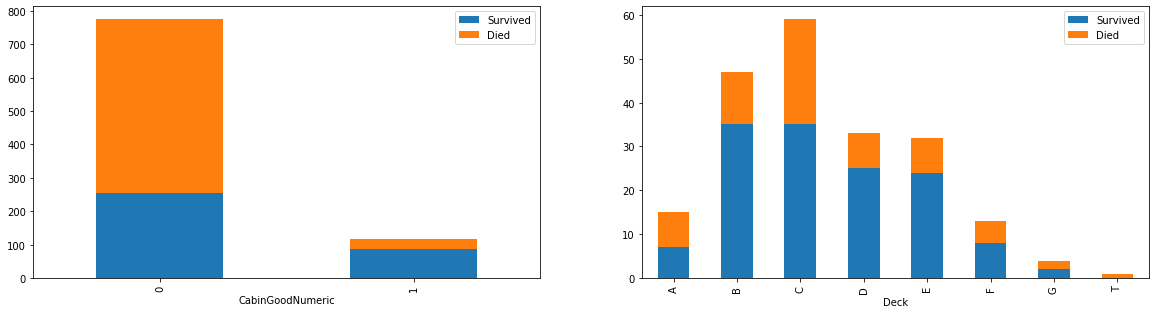

In [12]:
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

f, (ax1, ax2) = plt.subplots(1, 2, False, figsize=(20,5))

# simply having s cabin assigned increases chances of survival
t_train['CabinGoodNumeric'] =  t_train['Deck'].map(lambda letter: 1 if (letter in "BDEG") else 0)
t_train_orig.groupby('CabinGoodNumeric').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax1)

# correlate deck with survival rate for assigned cabins
import string
t_train_orig[t_train_orig['Deck'] != 'U'].groupby('Deck').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax2)

# CabinGoodNumeric doesn't yet seem to inprove things.. can it be made to be useful?
# why is it not a very important feature according to random forrest.. is it because most people don't have a cabin?

{'bodies': [<matplotlib.collections.PolyCollection at 0x125482668>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x125472b38>,
 'cmins': <matplotlib.collections.LineCollection at 0x125482550>,
 'cbars': <matplotlib.collections.LineCollection at 0x125482a90>}

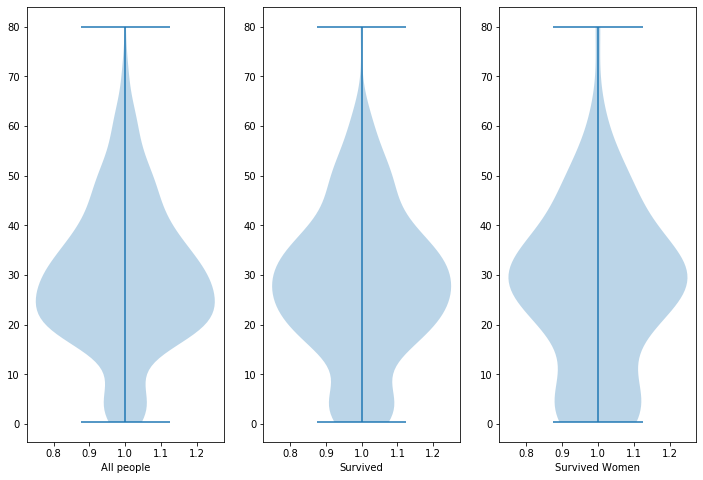

In [18]:
#plt.style.use('fivethirtyeight') # using the fivethirtyeight matplotlib theme
f, ax = plt.subplots(1, 3, sharex='col', figsize=(12,8))
age_data = t_train[['Age', 'SexNumeric', 'Survived']].dropna()
ax[0].set_xlabel('All people')
ax[0].violinplot(dataset=age_data['Age'])
ax[1].set_xlabel('Survived')
ax[1].violinplot(dataset=age_data[age_data['Survived'] == 1]['Age'])
ax[2].set_xlabel('Survived Women')
ax[2].violinplot(dataset=age_data[(age_data['Survived'] == 1) & (age_data['SexNumeric'] == 0)]['Age'])




This tells us that of the people who survived more were closer to their 30's than the bulk of the people on the boat who were, most of which were in their mid-20's presumably because they were less wealthy and were on decks closer to the bottom of the ship?  Maybe.. this is correlated with the observation that looking at the women survivors more of them were in their 30's.

### apply Random Forrest Classifier to the features


In [14]:
from sklearn.ensemble import RandomForestClassifier

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric', 'CabinGoodNumeric']

X = t_train[feature_cols]
y = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

rfc = RandomForestClassifier(n_estimators=100, max_depth=8,
                             min_samples_split = 3, min_samples_leaf=2, 
                             max_features=0.75, n_jobs=-1)
rfc.fit(X_train,y_train) 

print(f'feature importance: {rfc.feature_importances_}')
print(f'score train: {rfc.score(X_train, y_train)}')
print(f'score:       {rfc.score(X_test, y_test)}')


feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances

feature importance: [0.27646401 0.12110657 0.20968785 0.35163295 0.04110862]
score train: 0.8892455858747994
score:       0.8022388059701493


,importance
TitleNumeric,0.351633
FareAdjusted,0.276464
SexNumeric,0.209688
Pclass,0.121107
CabinGoodNumeric,0.041109


## Using Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

prob = lr.predict_proba(X)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X_test, y_test)}')


probabilty (count = 891
[[0.93654474 0.06345526]
 [0.14421731 0.85578269]
 [0.38853999 0.61146001]
 ...
 [0.39300954 0.60699046]
 [0.72998551 0.27001449]
 [0.93658066 0.06341934]]



ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 5 

## Using K-Nearest Neighbors
because.. why not?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Odds and Ends -- things I may want to use but are not currently helping

In [ ]:
# Things I did not use

# passenger has a cabin (if NaN, no cabin)
t_train['CabinPresent'] = t_train['Cabin'].fillna(0)
t_train['CabinPresent'] = np.where(t_train['CabinPresent'] != 0, 1, 0)

# location of cabin.. naive mapping based on the first letter of the Cabin location 
import string
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

# thought large number of siblings might help (it didn't)
t_train['SibSpLarge'] = t_train['SibSp'].map(lambda ct: 1 if ct > 3 else 0)
#t_train['SibSpLarge'].value_counts()

# people with the same last name may be a family; add feature that represent this count to each person
# doesn't seem to help
t_train['LastName'] = t_train['Name'].map(lambda name: name.split(',')[0])
familyCount = t_train.groupby('LastName')['LastName'].count()
t_train['FamilyCount'] = t_train['LastName'].map(lambda lastName: familyCount[lastName])
t_train['FamilyScore'] = t_train.SibSp + t_train.Parch

t_train['FamSize_Single'] = t_train['FamilyScore'].map(lambda score: score == 1)
t_train['FamSize_Small'] = t_train['FamilyScore'].map(lambda score: 1 < score <= 3)
t_train['FamSize_Medium'] = t_train['FamilyScore'].map(lambda score: 3 < score <= 5)
t_train['FamSize_Large'] = t_train['FamilyScore'].map(lambda score: 5 < score)
# next, try using the SibSp to correlate against this count..
# but do people with siblings or spouses have a higher chance of surviving? 

#t_train['Fare'].map(lambda amt: int(amt / 10) * 10).value_counts()
ave_fare = t_train['Fare'].median()
t_train['FareWithDefault'] = t_train['Fare'].map(lambda fare: fare if fare > 0 else ave_fare)


# this actually hurts
t_train['IsChild'] = t_train['AgeAdjusted'].map(lambda age: 1 if (age <= 12.0) else 0)


# extract titles
get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
titles = t_train['Title'].unique()

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: get_index(title, titles))

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']

In [ ]:
# explore correlation between features
t_train_corr = t_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .6)].groupby('Feature 1')
for feature in feature_cols:
    print(groups.get_group(feature))